In [1]:
import jax
jax.config.update('jax_enable_x64',True)
jax.config.update('jax_platform_name','cpu')

import jax.numpy as jnp

from astropy.cosmology import Planck15 as cosmo
from astropy import constants as const
from astropy import units as u

import numpy as np
import timeit
import time

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Constants
# --------------------------------------------------------

h70 = cosmo.H0.value/7.00E+01

Tcmb = 2.7255
kb = const.k_B.value
me = ((const.m_e*const.c**2).to(u.keV)).value
h  = const.h.value
Xthom = const.sigma_T.to(u.cm**2).value

Mparsec = u.Mpc.to(u.cm)

# Cosmology 
# --------------------------------------------------------
dzline = np.linspace(0.00,5.00,1000)
daline = cosmo.angular_diameter_distance(dzline)/u.radian
nzline = cosmo.critical_density(dzline)
hzline = cosmo.H(dzline)/cosmo.H0

daline = daline.to(u.Mpc/u.arcsec)
nzline = nzline.to(u.Msun/u.Mpc**3)

dzline = jnp.array(dzline)
hzline = jnp.array(hzline.value)
nzline = jnp.array(nzline.value)
daline = jnp.array(daline.value)

In [4]:
# Compton y to Kcmb
# --------------------------------------------------------
@jax.partial(jax.jit, static_argnums = (0,1))
def y2K_CMB(freq,Te):
    x = freq*h/kb/Tcmb
    xt = x/jnp.tanh(0.5*x)
    st = x/jnp.sinh(0.5*x)
    Y0 = -4.0+xt
    Y1 = -10.+((47./2.)+(-(42./5.)+(7./10.)*xt)*xt)*xt+st*st*(-(21./5.)+(7./5.)*xt)
    Y2 = (-15./2.)+((1023./8.)+((-868./5.)+((329./5.)+((-44./5.)+(11./30.)*xt)*xt)*xt)*xt)*xt+ \
       ((-434./5.)+((658./5.)+((-242./5.)+(143./30.)*xt)*xt)*xt+(-(44./5.)+(187./60.)*xt)*(st*st))*st*st
    Y3 = (15./2.)+((2505./8.)+((-7098./5.)+((14253./10.)+((-18594./35.)+((12059./140.)+((-128./21.)+(16./105.)*xt)*xt)*xt)*xt)*xt)*xt)*xt+ \
       (((-7098./10.)+((14253./5.)+((-102267./35.)+((156767./140.)+((-1216./7.)+(64./7.)*xt)*xt)*xt)*xt)*xt) +
       (((-18594./35.)+((205003./280.)+((-1920./7.)+(1024./35.)*xt)*xt)*xt) +((-544./21.)+(992./105.)*xt)*st*st)*st*st)*st*st
    Y4 = (-135./32.)+((30375./128.)+((-62391./10.)+((614727./40.)+((-124389./10.)+((355703./80.)+((-16568./21.)+((7516./105.)+((-22./7.)+(11./210.)*xt)*xt)*xt)*xt)*xt)*xt)*xt)*xt)*xt + \
       ((-62391./20.)+((614727./20.)+((-1368279./20.)+((4624139./80.)+((-157396./7.)+((30064./7.)+((-2717./7.)+(2761./210.)*xt)*xt)*xt)*xt)*xt)*xt)*xt + \
       ((-124389./10.)+((6046951./160.)+((-248520./7.)+((481024./35.)+((-15972./7.)+(18689./140.)*xt)*xt)*xt)*xt)*xt +\
       ((-70414./21.)+((465992./105.)+((-11792./7.)+(19778./105.)*xt)*xt)*xt+((-682./7.)+(7601./210.)*xt)*st*st)*st*st)*st*st)*st*st
    factor = Y0+(Te/me)*(Y1+(Te/me)*(Y2+(Te/me)*(Y3+(Te/me)*Y4)))
    return factor*Tcmb

@jax.partial(jax.jit,static_argnums=(0,))
def K_CMB2K_RJ(freq):
    x = freq*h/kb/Tcmb
    return jnp.exp(x)*x*x/jnp.expm1(x)**2

@jax.partial(jax.jit, static_argnums = (0,1))
def y2K_RJ(freq,Te):
    factor = y2K_CMB(freq,Te)
    return factor*K_CMB2K_RJ(freq)


In [96]:
# Beam-convolved gNFW profiel
# --------------------------------------------------------
def conv_int_gnfw(p,xi,yi,z,max_R=10.00,fwhm=8.7,freq=90e9,T_electron=5.0,r_map=15.0*60,dr=0.5):
    
    x0, y0, P0, c500, alpha, beta, gamma, m500 = p
    hz = jnp.interp(z,dzline,hzline)
    nz = jnp.interp(z,dzline,nzline)
    
    ap = 0.12
    
    r500 = (m500/(4.00*jnp.pi/3.00)/5.00E+02/nz)**(1.00/3.00)
    P500 = 1.65E-03*(m500/(3.00E+14/h70))**(2.00/3.00+ap)*hz**(8.00/3.00)*h70**2
    
    dR = max_R/2e3
    r = jnp.arange(0.00,max_R,dR)+dR/2.00
    x = r/r500
    pressure = P500*P0/((c500*x)**gamma*(1.00+(c500*x)**alpha)**((beta-gamma)/alpha))
    rmap = jnp.arange(1e-10,r_map,dr) 
    r_in_Mpc = rmap*(jnp.interp(z,dzline,daline))
    rr = jnp.meshgrid(r_in_Mpc,r_in_Mpc)
    rr = jnp.sqrt(rr[0]**2+rr[1]**2)
    yy = jnp.interp(rr,r,pressure,right=0.)
    
    XMpc = Xthom*Mparsec
    
    ip = jnp.sum(yy,axis=1)*2.*XMpc/(me*1000)
    
    x = jnp.arange(-1.5*fwhm//(dr),1.5*fwhm//(dr))*(dr)
    nx = x.shape[0]//2+1
    
    ipp = jnp.concatenate((ip[0:nx][::-1],ip))
    
    return ip

In [97]:
def convo(ip,dr=0.5,fwhm=8.7):
    x = jnp.arange(-1.5*fwhm//(dr),1.5*fwhm//(dr))*(dr)
    B_1 = 0.94
    B_2 = 0.06
    sigma_1 = 3.69 #arcsec
    sigma_2 = 12.1 #arcsec
    
    beam_mustang = B_1*jnp.exp(-1*x**2/(2*sigma_1**2))+B_2*jnp.exp(-1*x**2/(2*sigma_2**2))
    
    beam_mustang = beam_mustang/jnp.sum(beam_mustang)
    #beam = jnp.exp(-4*np.log(2)*x**2/fwhm**2)
    #beam = beam/jnp.sum(beam)
    
    nx = x.shape[0]//2+1
    
    ipp = jnp.concatenate((ip[0:nx][::-1],ip))
    ip = jnp.convolve(ipp,beam_mustang,mode='same')[nx:]
    
    ip = ip*y2K_RJ(freq=freq,Te=T_electron)
    
    dx = (xi-x0)*jnp.cos(yi)
    dy  = yi-y0
    dr = jnp.sqrt(dx*dx + dy*dy)*180./np.pi*3600. 
    return jnp.interp(dr,rmap,ip,right=0.)
    

In [67]:
def pressure_bar(p,xi,yi,z,max_R=10.00,fwhm=8.7,freq=90e9,T_electron=5.0,r_map=15.0*60,dr=0.5):
    
    
    x0, y0, P0, c500, alpha, beta, gamma, m500 = p
    hz = jnp.interp(z,dzline,hzline)
    nz = jnp.interp(z,dzline,nzline)
    
    ap = 0.12
    
    r500 = (m500/(4.00*jnp.pi/3.00)/5.00E+02/nz)**(1.00/3.00)
    P500 = 1.65E-03*(m500/(3.00E+14/h70))**(2.00/3.00+ap)*hz**(8.00/3.00)*h70**2
    
    dR = max_R/2e3
    r = jnp.arange(0.00,max_R,dR)+dR/2.00
    x = r/r500
    pressure = 0.3*P500*P0/((c500*x)**gamma*(1.00+(c500*x)**alpha)**((beta-gamma)/alpha))
    rmap = jnp.arange(1e-10,r_map,dr) 
    r_in_Mpc = rmap*(jnp.interp(z,dzline,daline))
    rr = jnp.meshgrid(r_in_Mpc,r_in_Mpc)
    rr = jnp.sqrt((rr[0])**2+(rr[1])**2)
    yy = jnp.interp(rr,r,pressure,right=0.)
    
    XMpc = Xthom*Mparsec
    
    ip = jnp.sum(yy,axis=1)*2.*XMpc/(me*1000)
    
    x = jnp.arange(-1.5*fwhm//(dr),1.5*fwhm//(dr))*(dr)
    B_1 = 0.94
    B_2 = 0.06
    sigma_1 = 3.69 #arcsec
    sigma_2 = 12.1 #arcsec
    
    beam_mustang = B_1*jnp.exp(-1*x**2/(2*sigma_1**2))+B_2*jnp.exp(-1*x**2/(2*sigma_2**2))
    
    beam_mustang = beam_mustang/jnp.sum(beam_mustang)
    #beam = jnp.exp(-4*np.log(2)*x**2/fwhm**2)
    #beam = beam/jnp.sum(beam)
    
    nx = x.shape[0]//2+1
    
    ipp = jnp.concatenate((ip[0:nx][::-1],ip))
    ip = jnp.convolve(ipp,beam_mustang,mode='same')[nx:]
    
    ip = ip*y2K_RJ(freq=freq,Te=T_electron)
    
    dx = (xi-x0)*jnp.cos(yi)
    dy  = yi-y0
    dr = jnp.sqrt(dx*dx*25 + dy*dy*2.25)*180./np.pi*3600. 
    
    return ip
    

In [68]:
def bimodal_system(p,xi,yi,z,separation):
    
    max_R=10.00
    fwhm=8.7
    freq=90e9
    T_electron=5.0
    r_map=15.0*60
    dr=0.5
    
    separation_radians=(separation/3600)*np.pi/180.
    x0, y0, P0, c500, alpha, beta, gamma, m500 = p
    x0_1 = x0 - separation_radians/2.0
    x0_2 = x0 + separation_radians/2.0
    
    p1 = [x0_1,y0,P0,c500,alpha,beta,gamma,m500]
    p2 = [x0_2,y0,P0,c500,alpha,beta,gamma,m500]
    
    
    cluster1=conv_int_gnfw(p1,xi,yi,z,max_R,fwhm,freq,T_electron,r_map,dr)
    cluster2=conv_int_gnfw(p2,xi,yi,z,max_R,fwhm,freq,T_electron,r_map,dr)
    bar=pressure_bar(p,xi,yi,z,max_R,fwhm,freq,T_electron,r_map,dr)
    
    merger = cluster1+cluster2+bar
    return merger

In [87]:
def maincore_plus_extension(p,xi,yi,z,separation):
    x0, y0, P0, c500, alpha, beta, gamma, m500_core, m500_ext = p
    
    max_R=10.00
    fwhm=8.7
    freq=90e9
    T_electron=5.0
    r_map=15.0*60
    dr=0.5
    
    
    separation_radians=(separation/3600)*np.pi/180
    x0_1 = x0 - separation_radians/2.0
    x0_2 = x0 + separation_radians/2.0
    
    p_core = [x0_1,y0,P0,c500,alpha,beta,gamma,m500_core]
    p_ext = [x0_2,y0,P0,c500,alpha,beta,gamma,m500_ext]
    
    core=conv_int_gnfw(p_core,xi,yi,z,max_R,fwhm,freq,T_electron,r_map,dr)
    extension=conv_int_gnfw(p_ext,xi,yi,z,max_R,fwhm,freq,T_electron,r_map,dr)
    core_extension = core+extension
    
    return core_extension

In [ ]:
gamma_ad=5./3.
M=3.
P1_P2=2*M**2*gamma_ad/(gamma_ad+1)+(gamma_ad-1)/(gamma_ad+1)

In [78]:
#parameters:
radius_500 = 1 #1 mpc = 1000 kpc 
m_500=(4.*np.pi/3.)*radius_500**3/(500*nzline[80])
x0 = 0.0
y0 = 0.0
alpha=1.0510
beta=5.4905
gamma=0.3081
P0=8.403
c500=1.177

arcmin2_rads=(2./60.)*np.pi/180

p = [x0,y0,P0,c500,alpha,beta,gamma,m_500]


x=np.linspace(-1*arcmin2_rads,arcmin2_rads,1000)
y=np.linspace(-1*arcmin2_rads,arcmin2_rads,1000)

x_coords,y_coords = np.meshgrid(x,y)
z=0.4 #Romero et al 2015, Table 1

In [82]:
radius_core=1.
radius_ext= 0.3
m_500_core = (4.*np.pi/3.)*radius_core**3/(500*nzline[80])
m_500_ext = (4.*np.pi/3.)*radius_ext**3/(500*nzline[80])
p_core_ext = x0, y0, P0, c500, alpha, beta, gamma, m_500_core, m_500_ext

In [79]:
two_clusters=bimodal_system(p,x_coords,y_coords,1.,separation=25)

In [88]:
core_ext = maincore_plus_extension(p_core_ext,x_coords,y_coords,z,separation=10)

In [91]:
from matplotlib.colors import LogNorm

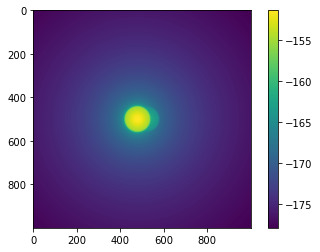

In [95]:
plt.imshow(np.log(np.abs(core_ext)))
plt.colorbar()

In [ ]:
core_plus_ext=maincore_plus_extension(p,1,0.8,x_coords,y_coords,separation=3)

In [ ]:
plt.imshow(core_plus_ext)
plt.colorbar()